# Label-free prediction of white blood cells

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [4]:
# data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [7]:
data_dir = Path("/home/maximl/scratch/data/wbc")

In [8]:
df = pq.read_table(data_dir / f"results/scip/202201141724/features.parquet").to_pandas()

In [9]:
cols = numpy.load(data_dir / "results/scip/202201141724/columns.npy", allow_pickle=True)
df = df[cols]

index = numpy.load(data_dir / "results/scip/202201141724/index.npy", allow_pickle=True)
df = df.loc[index]

df.shape

(247993, 2519)

In [10]:
glcms = set(df.filter(regex=".*glcm.*(BF1|BF2|SSC)$").columns)
combined_glcms = set(df.filter(regex=".*combined.*glcm.*(BF1|BF2|SSC)$").columns)
noncomb_glcms = glcms - combined_glcms

df = df.drop(columns=noncomb_glcms)

In [11]:
df = df[~df.filter(regex="(BF1|BF2|SSC)$").isna().any(axis=1)]
df.shape

(246928, 2447)

In [12]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df

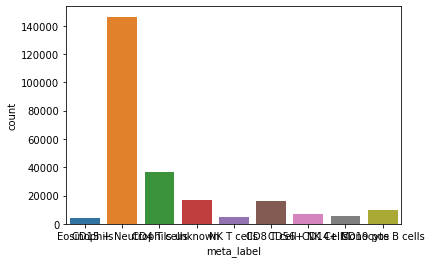

In [13]:
seaborn.countplot(x=df["meta_label"])

In [75]:
df["meta_label"].value_counts()

CD15 + Neutrophils    46326
CD4 T cells           36578
unknown               16630
CD8 T cell            15868
CD19 pos B cells       9574
CD56+ NK Cells         7135
CD14+ Monocyte         5373
NK T cells             5185
Eosinophils            3179
Eos                    1080
Name: meta_label, dtype: int64

In [15]:
neuts = df[df["meta_label"] == "CD15 + Neutrophils"].sample(n=110000).index

df = df.drop(labels=neuts)

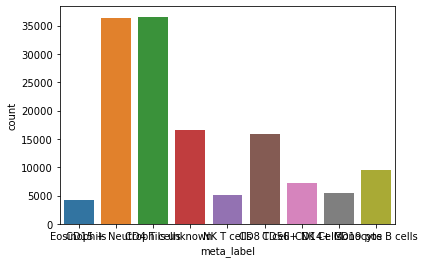

In [16]:
seaborn.countplot(x=df["meta_label"])

In [21]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

CPU times: user 929 ms, sys: 1.89 s, total: 2.82 s
Wall time: 5min 11s


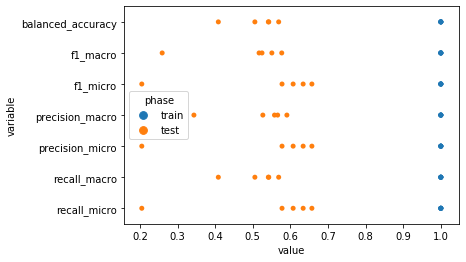

In [74]:
%%time
from sklearn import tree
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="(BF1|BF2|SSC)$"), y, 
    model
)

CPU times: user 9.05 s, sys: 4.27 s, total: 13.3 s
Wall time: 8min 44s


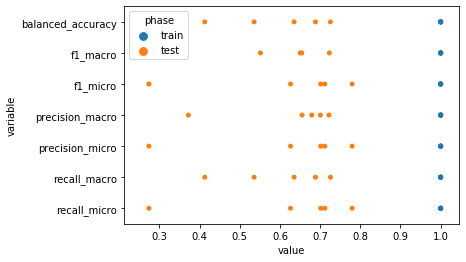

In [23]:
%%time
model_xgb = make_pipeline(
    RandomOverSampler(sampling_strategy="not majority", random_state=0),
    XGBClassifier(
        booster="gbtree",  
        objective="multi:softmax", 
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        n_estimators=500
    )
)
_ = predict_gates(
    df.filter(regex="(BF1|BF2|SSC)$"), y, 
    model_xgb
)